In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Helper functions / cached data
reports = os.listdir('reports')

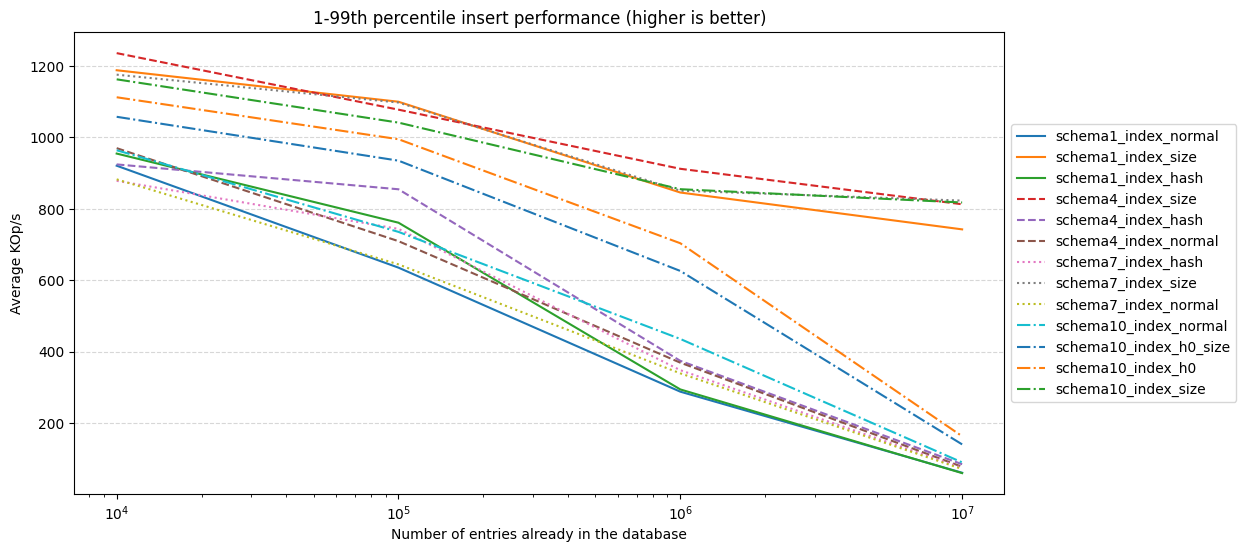

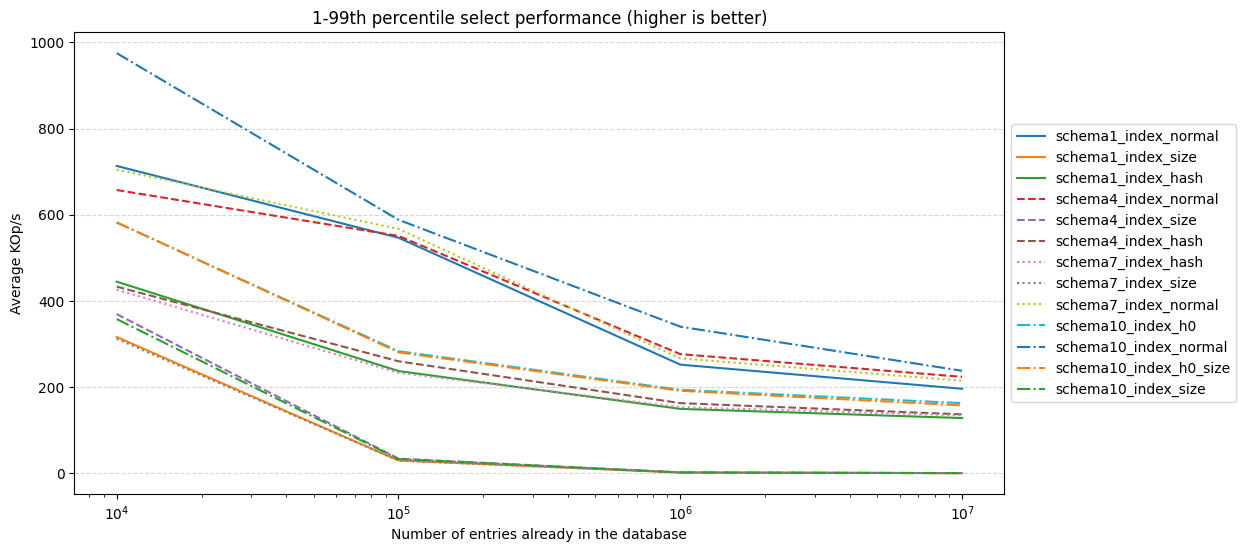

In [66]:
# Schemas
def read_schemas(filename):
    result = dict()
    sub_benchmarks = ['insert', 'select']
    for sub in sub_benchmarks:
        sub_dict = dict()
        matches = [f for f in reports if f.startswith(f'{filename}_{sub}')]
        for match in matches:
            subsub_dict = dict()
            subsub = match.removeprefix(f'{filename}_{sub}_').removesuffix('.csv')
            with open(f'reports/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                subsub_dict[entries] = inner
            sub_dict[subsub] = subsub_dict
        result[sub] = sub_dict
    return result

styles = ['solid', 'dashed', 'dotted', 'dashdot']
def plot_schema(idx, benchmark, style):
    schema = read_schemas(f'schema{idx}')
    for strategy in schema[benchmark]:
        values = [(k, v['1-99_avg_kops']) for k, v in schema[benchmark][strategy].items()]
        x, y = zip(*values)
        plt.plot(x, y, label=f'schema{idx}_{strategy}', linestyle=style)

for b in ['insert', 'select']:
    plt.figure(figsize=(12, 6))
    # Horizontal grid for each y tick
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, schema in enumerate([1, 4, 7, 10]):
        plot_schema(schema, b, styles[i % len(styles)])

    plt.title(f'1-99th percentile {b} performance (higher is better)')
    plt.xlabel('Number of entries already in the database')
    plt.ylabel('Average KOp/s')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

2018.29


Text(0.5, 1.0, 'Pragmas for mmap_size_64M')

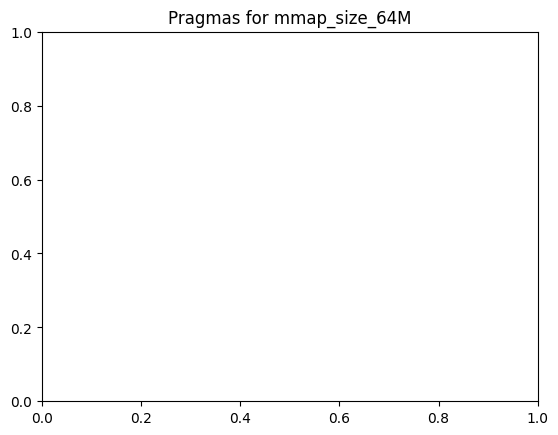

In [76]:
benchmarks = list(set([(f.split('_'))[1] for f in reports if f.startswith('pragmas')]))
def read_pragmas():
    result = dict()
    for b in benchmarks:
        result[b] = dict()
        matches = [f for f in reports if f.startswith(f'pragmas_{b}_')]
        for match in matches:
            subsub = match.removeprefix(f'pragmas_{b}_').removesuffix('.csv')
            result[b][subsub] = dict()
            with open(f'reports/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                result[b][subsub][entries] = inner
    return result

values = read_pragmas()

b = benchmarks[0]
sb = list(values[b].keys())[0]
e = 10000
print (values[b][sb][e]['1-99_avg_kops'])
plt.title(f'Pragmas for {sb}')